In [1]:
library(matrixStats) # rowMins()
require( spam) #to calculate distances
library(data.table)
library(ggplot2)
library(reshape2)

Warning message:
"package 'matrixStats' was built under R version 3.4.3"Loading required package: spam
Warning message:
"package 'spam' was built under R version 3.4.1"Loading required package: dotCall64
Warning message:
"package 'dotCall64' was built under R version 3.4.1"Loading required package: grid
Spam version 2.1-1 (2017-07-02) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following objects are masked from 'package:base':

    backsolve, forwardsolve


Attaching package: 'reshape2'

The following objects are masked from 'package:data.table':

    dcast, melt



Functions to calculate distances:
1. Between spots
2. Between spots and surfaces vertices
3. Between spots and surface center of mass

In [21]:
#Create function to calcualte distances for a postiion table
CalculateSpotDistance<-function(PositionTableX, PositionTableY, DistanceThreshold, fileName, plotType){
  #Calculate nearest distance
  #Here Posistion Y: DATA1, because we collect @entries with @colindices
  ds <- nearest.dist(x=PositionTableX, y=PositionTableY, method = "euclidean", delta=DistanceThreshold, upper=NULL)
  #Plot histogram = optional
    ##for linux
  #tiff(paste("/home/nani/Documents/Plots/", fileName,"_",plotType ,".tiff", sep=""))
    ##for windows Z:\\Result0309\\s20_Wt"
  #tiff(paste("C:\\Documents\Plots\\", fileName,"_",plotType ,".tiff", sep=""))
    ########
  hist(diff( ds@entries),main=paste("Distances frequency within delta - ", plotType, sep=""), sub=fileName)
  dev.off() 
  #Get data frame containing min, max, mean distance to next point and number of spots close by (below delta threshold)
  ds@colindices<-ds@colindices[ds@entries>0]
  ds@entries<-ds@entries[ds@entries>0]
  dt <- as.data.table(ds@colindices)[, list(list(ds@entries[.I])), by = ds@colindices]
  CollectDist <- data.frame(SpotId = unlist(dt$`ds@colindices`),
                            NumbSpot = unlist(dt[,list(lapply(V1,length))]),
                            MeanDist = unlist(dt[,list(lapply(V1,mean))]),
                            MinDist = unlist(dt[,list(lapply(V1,min))]), 
                            MaxDist = unlist(dt[,list(lapply(V1,max))])
  )
  colnames(CollectDist)<-c("SpotId", "NumbSpot", "MeanDist", "MinDist", "MaxDist")
  CollectDist
}

#Calculate distance between each spot and a list of spots
CalculateMinSpotSpotDistance<-function(SpotPosition, RefPos, GetIndex, vDelta){
  ds2 <- nearest.dist(x=SpotPosition, y=RefPos, method = "euclidean", delta=vDelta, upper=NULL)
  MinDistance <- as.matrix(apply(ds2,1,min))
  if (GetIndex){
      MinDistanceIndex <-  as.matrix(apply(ds2, 1, which.min)) #I need the index as well to get features of the closest RefPos spot  
  }else{
      MinDistanceIndex <- "" 
  }
  list(Dist=MinDistance,Ind=MinDistanceIndex) 
}

#Calculate distance from each surface = set a high delta
CalculateSpotSurfaceDistance<-function(SpotPosition, SurfacePosition, SurfaceFeat){
  #Note: Here delta is set a high value 100: I want all the distances
  #STEP1 : Calculate the distance to center of masses of nucleus, of the nucleolus and all the chromocenters
  FirstTab<-SurfacePosition[1:2,] #this table contains postions for Nucleus and nucleolus only
  CC<-SurfacePosition[3:nrow(SurfacePosition),] #this one for the CC
  CCF<-SurfaceFeat[3:nrow(SurfaceFeat),] #Get CC features
  meanCC<-colMeans(CC) #calculate average position for all CC
  FirstTab<-rbind(FirstTab, meanCC)
  ds <- nearest.dist(x=SpotPosition, y=FirstTab, method = "euclidean", delta=100, upper=NULL)
  ds <-data.frame(as.matrix(ds))
  #STEP2: Get minimum distance spot-CC for each spot
  Res <- CalculateMinSpotSpotDistance(SpotPosition, CC, TRUE, 5)
  ds<-cbind(ds, Res$Dist)
  FeatVect<-CCF[Res$Ind,]
  rownames(FeatVect)<-seq(1, nrow(FeatVect))
  ds<-cbind(ds, FeatVect)
  colnames(ds)<-c("NucleusCMDist", "NucleolusCMDist", "MeanCCDist", "ClosestCCCMDist",paste0(names(FeatVect), "CC"))
  ds$SpotId <- seq(1, nrow(ds)) #Since I transform spam into a matrix, I get the row = SpotId
  ds
}

clamp <- function(x, xmax) { ifelse(x<=xmax, x, xmax) }

# Pilot phase
## Process one image 
...from segmented spots

Process one file
(...For one image ID=1)
1. Read position .csv files for each spot type (SP=0,1,2): Position_SP*_Obs_1.csv
2. Read intensity .csv files for each spot type (SP=0,1,2): Intensity_SP*_Obs_1.csv
3. Set intensity threshold and select spots with higher intensities = Spots1,Spots2, Spots3 
4. rbind these data frames Intensity for intensities, Data1 for position
5. Calculate distance : CalculateSpotDistance (Data1, x) where x=c(Spots1,Spots2, Spots3) -seperately because I want to count the number of closest spots for each spot type
6. cbind distance and intensity dataframes = Intensity
7. Read surface features: SurfaceFeatures_1.csv 
9. Calculate distance with each surface CalculateSpotSurfaceDistance()
10. Merge resulting table with Intensity
11. Final table: columns= FileName, SpotType, Intensities *3channels, Distances("NumbSpot", "MeanDist", "MinDist", "MaxDist")*3, Mask (-1: observed, 0,1), SegmentationIntensity
12. Remove outliers from all features
13. The following features are scaled by image: 
#[1] "IntensityCh0"   "IntensityCh1"   "IntensityCh2"   "IntensityCh3"   "Sp1NumbSpot"    "Sp2NumbSpot"    "Sp3NumbSpot"    "Nucleus"       
#[9] "Nucleolus"      "MeanCC"         "ClosestCC"      "VolumeCC"       "IntensityCh0CC" "IntensityCh1CC" "IntensityCh2CC" "IntensityCh3CC"

In [60]:
ProcessOneImage<-function(MotherFolder, ImageId, FileName){
  n <- 3 #declaring number of segemented channels
  delta <- 0.2 #declaring the highest distance threshold
  #I increased delta from 0.1, because with this value on my test sample, I only get 1% spots having at least one neihboring spot
  #STEP1: Get positions and intensities of all spots in 2 dataframes
  Data1 <- data.frame(matrix(,nrow=0, ncol=3)) #will contain positions of spots
  Intensity <- data.frame(matrix(,nrow=0, ncol=n+1)) #will contain intensities of spots (n+DAPI)
  ChannelType <- c()
  CollectSepSpots <- as.list(rep("", n))
  for (ch in seq(0,n-1))
    {
    FilePath <- paste(MotherFolder, "/Position_SP",ch , "_Obs_", ImageId,".csv", sep="") #For linux
    #FilePath <- paste(MotherFolder, "\\Position_SP",ch , "_Obs_", ImageId,".csv", sep="") #For windows
    Spots <- read.csv(file=FilePath, header = TRUE, sep = ",")
    FilePath <- paste(MotherFolder, "/Intensity_SP",ch , "_Obs_", ImageId,".csv", sep="") #For linux
    #FilePath <- paste(MotherFolder, "\\Intensity_SP",ch , "_Obs_", ImageId,".csv", sep="")#For windows
    Int <- read.csv(file=FilePath, header = TRUE, sep = ",")
    removeNullIntensity <- which(Int[paste("X", ch+1, sep="")]> 0) # keep only spots with intensity >0
    Spots <- Spots[removeNullIntensity, ]
    print(paste0("Sp", dim(Spots)))
    Data1 <- rbind(Data1, Spots)
    Int <- Int[removeNullIntensity, ]
    print(paste0("Sp", dim(Int)))
    Intensity <- rbind(Intensity, Int)
    ChannelType <- c(ChannelType, rep(ch+1,nrow(Spots))) #vector to keep track of channel type
    CollectSepSpots[[ch+1]] <- Spots
    rm(Int, Spots, removeNullIntensity) #Free RAM
    print(ch)
  }
  names(Intensity) = paste0("IntensityCh", seq(0,n))
  Intensity$FociType=ChannelType
  #STEP2 : Calculate distances between spots
  Intensity$SpotId=seq(1, nrow(Data1))
  for (ch in seq(1, n))
    {
    res<-CalculateSpotDistance(CollectSepSpots[[ch]], Data1, delta, FileName, paste("Channel", ch,sep=""))
    Features <- paste0(paste0("Sp", ch), c("NumbSpot","MeanDist", "MinDist", "MaxDist"))
    colnames(res) <- c("SpotId", Features)
    Intensity <- merge(Intensity, res, all=TRUE)
  }
  rm(ChannelType, CollectSepSpots, res) #free RAM space
  #STEP3 : Read SurfaceFeatures file and calculate spot-surface distances
  FilePath <- paste(MotherFolder, "/SurfaceFeatures_",ImageId ,".csv", sep="") # for linux
  #FilePath <- paste(MotherFolder, "\\SurfaceFeatures_",ImageId ,".csv", sep="") #for windows
  Surface <- read.csv(file=FilePath, header = TRUE, sep = ",")
  Pos <- Surface[2:4]
  Feat <- Surface[5:9]
  SurfSPot<-CalculateSpotSurfaceDistance(Data1, Pos, Feat)
  Intensity<- merge(Intensity, SurfSPot, all=TRUE)
  rm(SurfSPot, Pos,  Surface, Data1) #Free RAM
  #STEP4: Add in columns with nucleus and nucleolus features
  NucleusF<-Feat[rep(1, nrow(Intensity)),] #this table contains nucleus features 
  names(NucleusF)<-paste0("N1", names(NucleusF))
  Intensity<-cbind(Intensity, NucleusF)
  NucleusF<-Feat[rep(2, nrow(Intensity)),] #this table contains nucleolus features
  names(NucleusF)<-paste0("N2", names(NucleusF))
  Intensity<-cbind(Intensity, NucleusF)
  Intensity$File=FileName
  rm(NucleusF)
  #Replace outliers with max and min values for each column
  #Summary Data befoe clamp = optional
  #mylist<-lapply(Intensity, summary)
  #txtPath<-'/home/nani/Documents/Plots/SummaryBeforeClamp.txt'
  #lapply(mylist, write, txtPath, append=TRUE) 
  drops <- c("SpotId","FociType", 'File') 
  IntensityRf<-Intensity[ , !(names(Intensity) %in% drops)]
  Intensity.quantiles <- apply(IntensityRf, 2, function(x, prob=0.9) { quantile(x, prob, names=F, na.rm=TRUE) })
  for (j in 1:ncol(IntensityRf)) {
      IntensityRf[,j] <- clamp(IntensityRf[,j], Intensity.quantiles[j])  
  }
  Intensity<-cbind(Intensity[ , (names(Intensity) %in% drops)], IntensityRf)
  rm(Intensity.quantiles, IntensityRf)
  #Summary Data after clamp = optional 
  #mylist<-lapply(Intensity, summary)
  #txtPath<-'/home/nani/Documents/Plots/SummaryAfterClamp.txt'
  #lapply(mylist, write, txtPath, append=TRUE) 
  #Scale selected features
  drops <- c("SpotId","FociType",'N1Volume','N1IntensityCh0','N1IntensityCh1', 'N1IntensityCh2', 'N1IntensityCh3', 'N2Volume','N2IntensityCh0','N2IntensityCh1', 'N2IntensityCh2','N2IntensityCh3', 'File',"Sp1MeanDist", "Sp1MinDist", "Sp1MaxDist", "Sp2MeanDist", "Sp2MinDist", "Sp2MaxDist", "Sp3MeanDist", "Sp3MinDist", "Sp3MaxDist") # these features are not to be scaled per image
  NormDf<-Intensity[ , !(names(Intensity) %in% drops)]
  NormDf<-as.data.frame(scale(NormDf))
  Intensity<-cbind(Intensity[ , (names(Intensity) %in% drops)], NormDf)
  SegmentationIntensity <- c()
  for (ch in seq(1, n))
  {
    SegmentationIntensity <- c(SegmentationIntensity, Intensity[Intensity$FociType==ch,paste("IntensityCh", ch, sep="")])
  }
  Intensity$SegmentChannel <- SegmentationIntensity
  Intensity
}


(...Test on one image)

In [30]:
    ##for linux
MotherFolder= "/home/nani/smb4k/BOTSERV4.UZH.CH/gr_ug_ext/mashen2/Result0309/s20_Wt/1/XTCountSpotPerShell_Result"
    ##for windows
#MotherFolder= "Z:\\Result0309\\s20_Wt"
res<-ProcessOneImage(MotherFolder, 1, "FileName")

[1] "Sp17493" "Sp3"    
[1] "Sp17493" "Sp4"    
[1] 0
[1] "Sp3426" "Sp3"   
[1] "Sp3426" "Sp4"   
[1] 1
[1] "Sp20420" "Sp3"    
[1] "Sp20420" "Sp4"    
[1] 2


In [31]:
print(dim(res))
print(names(res))
head(res)

[1] 41339    39
 [1] "SpotId"         "FociType"       "File"           "Sp1MeanDist"   
 [5] "Sp1MinDist"     "Sp1MaxDist"     "Sp2MeanDist"    "Sp2MinDist"    
 [9] "Sp2MaxDist"     "Sp3MeanDist"    "Sp3MinDist"     "Sp3MaxDist"    
[13] "N1Volume"       "N1IntensityCh0" "N1IntensityCh1" "N1IntensityCh2"
[17] "N1IntensityCh3" "N2Volume"       "N2IntensityCh0" "N2IntensityCh1"
[21] "N2IntensityCh2" "N2IntensityCh3" "IntensityCh0"   "IntensityCh1"  
[25] "IntensityCh2"   "IntensityCh3"   "Sp1NumbSpot"    "Sp2NumbSpot"   
[29] "Sp3NumbSpot"    "Nucleus"        "Nucleolus"      "MeanCC"        
[33] "ClosestCC"      "VolumeCC"       "IntensityCh0CC" "IntensityCh1CC"
[37] "IntensityCh2CC" "IntensityCh3CC" "SegmentChannel"


,SpotId,FociType,File,Sp1MeanDist,Sp1MinDist,Sp1MaxDist,Sp2MeanDist,Sp2MinDist,Sp2MaxDist,Sp3MeanDist,⋯,Nucleus,Nucleolus,MeanCC,ClosestCC,VolumeCC,IntensityCh0CC,IntensityCh1CC,IntensityCh2CC,IntensityCh3CC,SegmentChannel
1,1,1,FileName,0.1799320,0.1772048,0.1799320,NA,NA,NA,0.1343186,⋯,1.372635,1.340133,1.427632,0.3367606,2.186887,0.645331,0.2339479,0.4643934,0.4703115,1.1299431
1.1,2,1,FileName,0.1799320,0.1772048,0.1799320,NA,NA,NA,NA,⋯,1.372635,1.340133,1.427632,0.2801932,2.186887,0.645331,0.2339479,0.4643934,0.4703115,0.9732742
1.2,3,1,FileName,NA,NA,NA,NA,NA,NA,0.1810282,⋯,1.372635,1.340133,1.427632,0.1406041,2.186887,0.645331,0.2339479,0.4643934,0.4703115,0.9732742
1.3,4,1,FileName,NA,NA,NA,NA,NA,NA,0.1280749,⋯,1.372635,1.340133,1.427632,-0.5580463,2.186887,0.645331,0.2339479,0.4643934,0.4703115,1.1299431
1.4,5,1,FileName,NA,NA,NA,NA,NA,NA,NA,⋯,1.372635,1.340133,1.427632,-0.9296517,2.186887,0.645331,0.2339479,0.4643934,0.4703115,1.1299431
1.5,6,1,FileName,0.1812387,0.1772048,0.1895417,NA,NA,NA,0.1738021,⋯,1.372635,1.340133,1.427632,-1.2761698,2.186887,0.645331,0.2339479,0.4643934,0.4703115,0.9732742


(... dealing with missing data... this will be done later for the whole data frame in python)

In [32]:
drops <- c("Sp1MeanDist", "Sp1MinDist", "Sp1MaxDist", "Sp2MeanDist", "Sp2MinDist", "Sp2MaxDist", "Sp3MeanDist", "Sp3MinDist", "Sp3MaxDist") # these features are not to be scaled per image
CleanDf<-res
#missing values as number of spots within radius is set to 0
CleanDf$Sp1NumbSpot[is.na(CleanDf$Sp1NumbSpot)]<-0
CleanDf$Sp2NumbSpot[is.na(CleanDf$Sp2NumbSpot)]<-0
CleanDf$Sp3NumbSpot[is.na(CleanDf$Sp3NumbSpot)]<-0
#missing values as distance from spots within radius is set to 10
CleanDf[is.na(CleanDf)] <- 10
head(CleanDf)

,SpotId,FociType,File,Sp1MeanDist,Sp1MinDist,Sp1MaxDist,Sp2MeanDist,Sp2MinDist,Sp2MaxDist,Sp3MeanDist,⋯,Nucleus,Nucleolus,MeanCC,ClosestCC,VolumeCC,IntensityCh0CC,IntensityCh1CC,IntensityCh2CC,IntensityCh3CC,SegmentChannel
1,1,1,FileName,0.1799320,0.1772048,0.1799320,10,10,10,0.1343186,⋯,1.372635,1.340133,1.427632,0.3367606,2.186887,0.645331,0.2339479,0.4643934,0.4703115,1.1299431
1.1,2,1,FileName,0.1799320,0.1772048,0.1799320,10,10,10,10.0000000,⋯,1.372635,1.340133,1.427632,0.2801932,2.186887,0.645331,0.2339479,0.4643934,0.4703115,0.9732742
1.2,3,1,FileName,10.0000000,10.0000000,10.0000000,10,10,10,0.1810282,⋯,1.372635,1.340133,1.427632,0.1406041,2.186887,0.645331,0.2339479,0.4643934,0.4703115,0.9732742
1.3,4,1,FileName,10.0000000,10.0000000,10.0000000,10,10,10,0.1280749,⋯,1.372635,1.340133,1.427632,-0.5580463,2.186887,0.645331,0.2339479,0.4643934,0.4703115,1.1299431
1.4,5,1,FileName,10.0000000,10.0000000,10.0000000,10,10,10,10.0000000,⋯,1.372635,1.340133,1.427632,-0.9296517,2.186887,0.645331,0.2339479,0.4643934,0.4703115,1.1299431
1.5,6,1,FileName,0.1812387,0.1772048,0.1895417,10,10,10,0.1738021,⋯,1.372635,1.340133,1.427632,-1.2761698,2.186887,0.645331,0.2339479,0.4643934,0.4703115,0.9732742


(...check that selected features are scaled)

In [33]:
drops <- c('N1Volume','N1IntensityCh0','N1IntensityCh1', 'N1IntensityCh2', 'N1IntensityCh3', 'N2Volume','N2IntensityCh0','N2IntensityCh1', 'N2IntensityCh2','N2IntensityCh3',"Sp1MeanDist", "Sp1MinDist", "Sp1MaxDist", "Sp2MeanDist", "Sp2MinDist", "Sp2MaxDist", "Sp3MeanDist", "Sp3MinDist", "Sp3MaxDist") # these features are not to be scaled per image
res.long<-CleanDf[ , !(names(CleanDf) %in% drops)]
res.long<-melt(res.long,id.vars=c("SpotId","File","FociType"))
#Next, as during importing data letter X is added to variable names starting with number, remove it with substring().
#df.long$variable<-substring(df.long$variable,2)

#### boxplot of all features before scaling####

Commented out the lines refering to scaling in function: ProcessOneImage

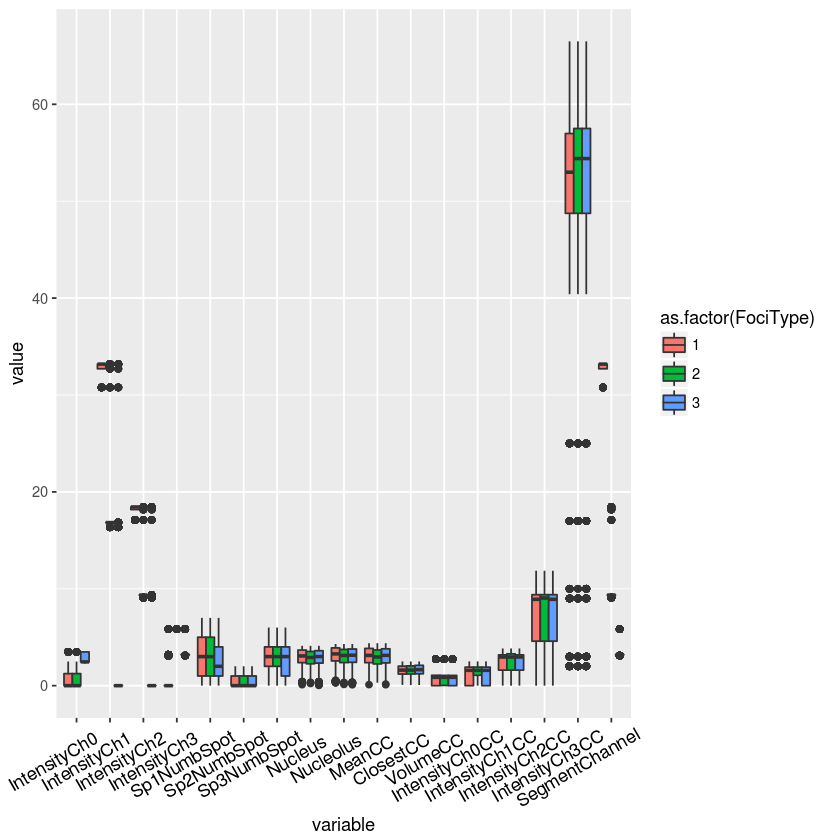

In [26]:
ggplot(res.long,aes(variable,value,fill=as.factor(FociType)))+
    theme(axis.text.x=element_text(color = "black", size=11, angle=30, vjust=.8, hjust=0.8)) +
   # geom_boxplot(position="dodge",stat="identity")
    geom_boxplot()

We need to scale  for the following reasons:
1. Normalise data in different images
2. If we proceed with machine learning without scaling some features will have more weight than others, as we can see from the plot above

#### After scaling####
(... same plot after scaling:  removed the comments on the lines refering to scaling and rerun previous cells)

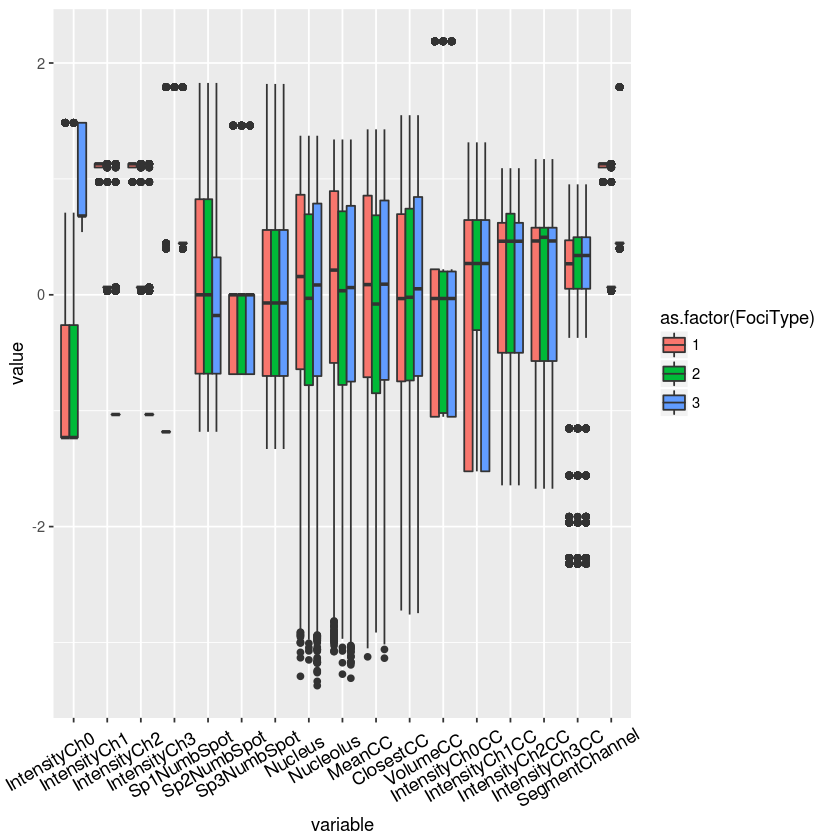

In [34]:
ggplot(res.long,aes(variable,value,fill=as.factor(FociType)))+
    theme(axis.text.x=element_text(color = "black", size=11, angle=30, vjust=.8, hjust=0.8)) +
   # geom_boxplot(position="dodge",stat="identity")
    geom_boxplot()

# Process plugin data 

## Check segmentation quality in all plugins

SelectFiles () function will:
- Reads the all the filenames in all folders 
- Select only filenames that has both simulated and observed data
- Read ploidy data frame
- Export df containing selecting filenames, and their ploidy index 

Then, I manually indexed the segmentation status (TRUE/FALSE) based on the snapshots saved by each plugin in Nucleolusok column in the same file (I also check the segmentation of CC and nucleus, sucess rate there is 100%, so nucleolus segmentation is going to be the discriminatory one)

I save the file and read it back again in this pipeline



In [19]:
SelectFiles <- function(FolderPath)
    {
      Data1 <- data.frame(matrix(,nrow=0, ncol=2)) #will contain positions of spots
      for (SubFolder in c(1,2,3,4,5))
        {
        FilePath<- paste(MotherFolder,SubFolder,  "XTCountSpotPerShell_Result","FileName.csv" , sep="/") # for linux
        # FilePath<- paste(MotherFolder,SubFolder, "XTCountSpotPerShell_Result","FileName.csv", sep="\\") # for windows
        OBsdf <- read.csv(file=FilePath, header = TRUE, sep = ",")
        FilePath<- paste(MotherFolder,SubFolder,  "XTSimulateRandomSpots_Result","FileName.csv" , sep="/") #for linux
        # FilePath<- paste(MotherFolder,SubFolder, "XTSimulateRandomSpots_Result","FileName.csv", sep="\\") # for windows
        Simdf <- read.csv(file=FilePath, header = TRUE, sep = ",")
        df<-merge(OBsdf, Simdf, all = FALSE)
        df$FolderID<-SubFolder
        Data1<-rbind(Data1, df)
      }
    names(Data1)<-c("FileName", "FolderID")
    FilePath<- paste(MotherFolder,"XTNucleiPloidy_Result", "XTNucleiPloidy_Result.csv" , sep="/")
    PLoidyDf <- read.csv(file=FilePath, header = TRUE, sep = ",")
    Data1<-merge(Data1, PLoidyDf, all = FALSE)
    Data1<-Data1[, names(Data1)%in%c("FileName","FolderID", "ClusterId")]
    Data1
}

In [20]:
MotherFolder= "/home/nani/smb4k/BOTSERV4.UZH.CH/gr_ug_ext/mashen2/Result0309/s20_Wt"
FileName<-SelectFiles(MotherFolder)

In [21]:
print(dim(FileName))
head(FileName)

[1] 48  3


FileName,FolderID,ClusterId
s20_wt_aa_series005.ims,1,P0
s20_wt_ab_series006.ims,1,P0
s20_wt_ac_series007.ims,1,P0
s20_wt_ad_series008.ims,1,P0
s20_wt_ae_series009.ims,1,P0
s20_wt_am_series017.ims,2,P0


In [22]:
#FilePath=paste(MotherFolder, "FileNames.csv", sep="/")
#write.csv(FileName, file = FilePath, quote=FALSE, row.names = FALSE)

In [8]:
table(FileName$ClusterId)


P0 P1 
34 14 

...Here, I manually indexed the segmentation station (TRUE/FALSE) based on the snapshots, and saved by each plugin

In [9]:
#MotherFolder<- "/home/nani/smb4k/BOTSERV4.UZH.CH/gr_ug_ext/mashen2/Result0309/s20_Wt" #for linux
MotherFolder<- "Z:\\Result0309\\s20_Wt" #for windows
FilePath=paste(MotherFolder, "FileNames.csv", sep="/") #on linux
#FilePath=paste(MotherFolder, "FileNames.csv", sep="\\") #on windows
SelectedIMages <- read.csv(file=FilePath, header = TRUE, sep = ",")
head(SelectedIMages)

FileName,FolderID,ClusterId,Nucleolusok
s20_wt_aa_series005.ims,1,P0,1
s20_wt_ab_series006.ims,1,P0,0
s20_wt_ac_series007.ims,1,P0,0
s20_wt_ad_series008.ims,1,P0,1
s20_wt_ae_series009.ims,1,P0,1
s20_wt_ag_series011.ims,1,P0,1


In [10]:
SelectedIMages<-SelectedIMages[SelectedIMages$Nucleolusok==1, names(SelectedIMages)%in%c("FileName", "ClusterId", "FolderID")]

In [11]:
head(SelectedIMages)

,FileName,FolderID,ClusterId
1,s20_wt_aa_series005.ims,1,P0
4,s20_wt_ad_series008.ims,1,P0
5,s20_wt_ae_series009.ims,1,P0
6,s20_wt_ag_series011.ims,1,P0
8,s20_wt_ai_series013.ims,1,P1
9,s20_wt_aj_series014.ims,1,P1


In [12]:
table(SelectedIMages$ClusterId)


P0 P1 
26 14 

## Process one image
This function will process images from XTSimulateRandomSpots_Result and XTCountSpotPerShell_Result, to get same resulting data frame

Function ProcessOneSimImage()
- Reads Position and intensity df for one image
- (Only reads simulations of 10000 spots because of RAM issue)
- (Takes into account only simulations outside of nucleolus and CCs , MaskID=1)
- Creates a FOCITYPE column to track different simulations or segementation channel depending on the data type: negative for simulated spots, positive for segmented ones
- Creates SEGMENTCHANNEL = intensity in the segmented channel for segmented spots, 0 for simulated ones
- Calculates distance b/n foci and surface vertices within a 1um radius
- Calculates distance b/n foci and other foci within a 0.2um radius
- Calculates distance b/n foci and closest CC', nucleolus' and nucleus'  center of masses
- Get features of closest CC, nucleolus, nucleus
- Replaces values of outliers with highest or lowest quantiles (prob set at 0.9)
- Scales numeric data - distances and intensities, specific for one spot. 

Notes Imaris Plugins:
- In XTSimulateRandomSpots.py: position df is transposed compared to position df in XTCountSpotPerShell.py
- In XTCountSpotPerShell.py: columns in intensity df are different than those in in XTSimulateRandomSpots.py

In [59]:
ProcessOneImage<-function(MotherFolder, ImageId,ImageIdVert, FileName, DataType, IsLinux){
  MaskId <- 1 # Only processing spots simulated outside of the CC and nucleolus
  BaseFolder <- ifelse(DataType=="Simulated","XTSimulateRandomSpots_Result", "XTCountSpotPerShell_Result" )
  SimPath <- paste(MotherFolder,BaseFolder, sep=ifelse(IsLinux, "/", "\\"))
  n <- 3 #declaring number of segemented channels
  delta <- 0.2 #declaring the highest distance threshold for distance between foci
  vdelta <- 1 #declaring the highest distance threshold for distance between surface vertices and foci, higher than 1um I get iteration and memory allocation error
  #STEP1: READ POSITION AND INTENSITY FOR EACH FOCI
  Data1 <- data.frame(matrix(,nrow=0, ncol=3)) #will contain positions of spots
  Intensity <- data.frame(matrix(,nrow=0, ncol=n+1)) #will contain intensities of spots (n+DAPI)
  SimN <- c()#vector to keep track of simulation ID / segmentation channel
  CollectSepSpots <- as.list(rep("", n))
  ListSegChan <-c() #vector to keep track of segmentation channel for observed spots, =0 for simulated ones
  Spottype <- ifelse(DataType=="Simulated", -1,1) #keep track of difference between simulated and segmented spots
  for (ch in seq(0,n-1)) #This loop over the different channels/simulations (total: 3)
    {      
    Fname <- ifelse(DataType=="Simulated", 
                    paste0("Position_SP0_ST",MaskId , "_Sml",ch,"_Sim_10000_", ImageId,".csv"),
                    paste0("Position_SP",ch , "_Obs_", ImageId,".csv")) 
    FilePath <- paste(SimPath, Fname, sep=ifelse(IsLinux, "/", "\\")) 
    Spots <- read.csv(file=FilePath, header = TRUE, sep = ",")
    if (DataType=="Simulated"){
        Spots <- as.data.frame(t(Spots))
    }
    Fname <- ifelse(DataType=="Simulated",
                    paste0("Intensity_SP0_ST",MaskId , "_Sml",ch,"_Sim_10000_", ImageId,".csv"),
                    paste0("Intensity_SP",ch , "_Obs_", ImageId,".csv"))
    FilePath <- paste(SimPath, Fname, sep=ifelse(IsLinux, "/", "\\")) 
    Int <- read.csv(file=FilePath, header = TRUE, sep = ",")
    print(paste0("Sp", dim(Spots)))
    Data1 <- rbind(Data1, Spots)
    print(paste0("Sp", dim(Int)))
    Intensity <- rbind(Intensity, Int)
    SimN <- c(SimN, rep(Spottype*(ch+1),nrow(Spots))) 
    SegChan <- ifelse(DataType=="Simulated",
                      rep(0,nrow(Spots)),
                      Int[[ch+1]])
    ListSegChan <- c(ListSegChan, SegChan) 
    CollectSepSpots[[ch+1]] <- Spots
    rm(Int, Spots) #Free RAM
    print(ch)
  }
  names(Intensity) <- paste0("IntensityCh", seq(0,n))
  Intensity$FociType <- SimN
  Intensity$SegmentChannel <- ListSegChan
  Intensity$SpotId <- seq(1, nrow(Data1))
  rm(ListSegChan, SimN) #Free RAM  
  #STEP2: CALCULATE DISTANCE BETWEEN EACH SPOT AND SURFACES
  for (surfName in c("Nucleus","Chromocenters","Nucleolus")){
    ColName <- paste0(surfName, "Dist")
    Fname <- paste0("XTGetSurfaceVertices_Result/", surfName, " Vertices_",ImageIdVert,".csv")
    FilePath <- paste(MotherFolder,Fname, sep=ifelse(IsLinux, "/", "\\"))
    Vertices <- read.csv(file=FilePath, header = TRUE, sep = ",")
    res<-CalculateSpotDistance(Vertices, Data1, vdelta, FileName, surfName) 
    Features <- paste0(surfName, c("_NumbSpot","_MeanDist", "_MinDist", "_MaxDist"))
    colnames(res) <- c("SpotId", Features)
    Intensity <- merge(Intensity, res,by = "SpotId", all.x=TRUE)
    rm(Vertices) #Free RAM  
    print(surfName)
  }
  #STEP3: CALCULATE DISTANCE BETWEEN FOCI
  for (ch in seq(1, n))
    {
    res<-CalculateSpotDistance(CollectSepSpots[[ch]], Data1, delta, FileName, paste("Channel", ch,sep=""))
    Features <- paste0(paste0("Sp", ch), c("NumbSpot","MeanDist", "MinDist", "MaxDist"))
    colnames(res) <- c("SpotId", Features)
    Intensity <- merge(Intensity, res, all=TRUE)
  }
  rm(CollectSepSpots, res) #free RAM space
  #STEP4 : CALCULATE DISTANCE BETWEEN EACH SPOT AND CENTER OF MASS OF EACH SURFACE
  Fname <- paste0("SurfaceFeatures_",ImageId ,".csv")  
  FilePath <- paste(SimPath, Fname, sep=ifelse(IsLinux, "/", "\\")) 
  Surface <- read.csv(file=FilePath, header = TRUE, sep = ",")
  Pos <- Surface[2:4]
  Feat <- Surface[5:9]
  SurfSPot<-CalculateSpotSurfaceDistance(Data1, Pos, Feat)
  Intensity<- merge(Intensity, SurfSPot, all=TRUE)
  rm(SurfSPot, Pos,  Surface, Data1) #Free RAM
  #STEP5: ADD COLUMNS WITH NUCLEUS AND NUCLEOLUS FEATURES
  NucleusF<-Feat[rep(1, nrow(Intensity)),] #this table contains nucleus features 
  names(NucleusF)<-paste0("N1", names(NucleusF))
  Intensity<-cbind(Intensity, NucleusF)
  NucleusF<-Feat[rep(2, nrow(Intensity)),] #this table contains nucleolus features
  names(NucleusF)<-paste0("N2", names(NucleusF))
  Intensity<-cbind(Intensity, NucleusF)
  Intensity$File=FileName
  rm(NucleusF)
  #STEP6: REMOVE OUTLIERS
  drops <- c("SpotId","FociType", 'File') 
  IntensityRf<-Intensity[ , !(names(Intensity) %in% drops)]
  Intensity.quantiles <- apply(IntensityRf, 2, function(x, prob=0.9) { quantile(x, prob, names=F, na.rm=TRUE) })
  for (j in 1:ncol(IntensityRf)) {
      IntensityRf[,j] <- clamp(IntensityRf[,j], Intensity.quantiles[j])  
  }
  Intensity<-cbind(Intensity[ , (names(Intensity) %in% drops)], IntensityRf)
  rm(Intensity.quantiles, IntensityRf)
  #STEP7: SCALE NUMERIC SPOT FEATURES
  drops <- c("SpotId","FociType",'N1Volume','N1IntensityCh0','N1IntensityCh1', 'N1IntensityCh2', 'N1IntensityCh3', 'N2Volume','N2IntensityCh0','N2IntensityCh1', 'N2IntensityCh2','N2IntensityCh3', 'File',"Sp1MeanDist", "Sp1MinDist", "Sp1MaxDist", "Sp2MeanDist", "Sp2MinDist", "Sp2MaxDist", "Sp3MeanDist", "Sp3MinDist", "Sp3MaxDist") # these features are not to be scaled per image
  NormDf<-Intensity[ , !(names(Intensity) %in% drops)]
  NormDf<-as.data.frame(scale(NormDf))
  Intensity<-cbind(Intensity[ , (names(Intensity) %in% drops)], NormDf)
  Intensity
}

In [45]:
HightPath <- "Z:\\Result0309\\s20_Wt"
IsLinux<-FALSE
highFol<-"1"
MotherFolder <- paste(HightPath, highFol, sep=ifelse(IsLinux, "/", "\\"))
res<- ProcessOneImage(MotherFolder, 1,1, "FileName", "Simulated", IsLinux)
head(res)

[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 0
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 1
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 2
[1] "Nucleus"
[1] "Chromocenters"
[1] "Nucleolus"


,SpotId,FociType,File,Sp1MeanDist,Sp1MinDist,Sp1MaxDist,Sp2MeanDist,Sp2MinDist,Sp2MaxDist,Sp3MeanDist,...,Sp3NumbSpot,NucleusCMDist,NucleolusCMDist,MeanCCDist,ClosestCCCMDist,VolumeCC,IntensityCh0CC,IntensityCh1CC,IntensityCh2CC,IntensityCh3CC
1,1,-1,FileName,0.1468509,0.1216553,0.1720465,0.1138333,0.1000000,0.1341641,0.1624808,...,-0.8599863,0.98861564,0.75523260,1.3898978,NaN,0.8304931,0.08970659,-0.1791679,0.01780915,0.51001446
1.1,2,-1,FileName,NA,NA,NA,0.1131371,0.1131371,0.1131371,NA,...,NA,-1.88869534,-1.35352728,-2.4990488,NaN,-0.7026417,-1.54556963,-1.4051785,-1.73772502,-0.09763833
1.2,3,-1,FileName,NA,NA,NA,0.1720465,0.1720465,0.1720465,0.1328826,...,0.4678845,0.69941323,0.40371185,0.7261024,NaN,0.8304931,0.08970659,-0.1791679,0.01780915,0.51001446
1.3,4,-1,FileName,0.1697056,0.1697056,0.1697056,NA,NA,NA,0.1790880,...,1.7957554,0.02402835,0.46788155,-0.1781700,NaN,0.8304931,0.08970659,-0.1791679,0.01780915,0.51001446
1.4,5,-1,FileName,0.1421954,0.1000000,0.1843909,0.1841765,0.1841765,0.1841765,0.1595768,...,0.4678845,-0.39321831,0.05577974,-0.4083738,NaN,0.8304931,0.08970659,-0.1791679,0.01780915,0.51001446
1.5,6,-1,FileName,NA,NA,NA,0.1886796,0.1881515,0.1960638,0.1886796,...,-0.8599863,0.10642049,0.39861039,-0.5250797,NaN,-1.2560431,0.95105110,1.2543644,1.21631643,-0.74373739


In [60]:
HightPath <- "Z:\\Result0309\\s20_Wt"
IsLinux<-FALSE
highFol<-"1"
MotherFolder <- paste(HightPath, highFol, sep=ifelse(IsLinux, "/", "\\"))
res<- ProcessOneImage(MotherFolder, 1,1, "FileName", "Segmented", IsLinux)
head(res)

[1] "Sp18425" "Sp3"    
[1] "Sp18425" "Sp4"    
[1] 0
[1] "Sp49916" "Sp3"    
[1] "Sp49916" "Sp4"    
[1] 1
[1] "Sp200435" "Sp3"     
[1] "Sp200435" "Sp4"     
[1] 2
[1] "Nucleus"
[1] "Chromocenters"
[1] "Nucleolus"


,SpotId,FociType,File,Sp1MeanDist,Sp1MinDist,Sp1MaxDist,Sp2MeanDist,Sp2MinDist,Sp2MaxDist,Sp3MeanDist,...,Sp3NumbSpot,NucleusCMDist,NucleolusCMDist,MeanCCDist,ClosestCCCMDist,VolumeCC,IntensityCh0CC,IntensityCh1CC,IntensityCh2CC,IntensityCh3CC
1,1,1,FileName,0.1799320,0.1790508,0.1799320,NA,NA,NA,0.1239824,...,-2.6354360,1.372691,1.347379,1.397345,NaN,-1.195434,0.928025,1.22035,1.210985,-0.5991082
1.1,2,1,FileName,0.1799320,0.1790508,0.1799320,NA,NA,NA,0.1541594,...,-2.3368682,1.372691,1.347379,1.397345,NaN,-1.195434,0.928025,1.22035,1.210985,-0.5991082
1.2,3,1,FileName,NA,NA,NA,0.1514452,0.1131683,0.1897220,0.1451318,...,-2.1875842,1.372691,1.347379,1.397345,NaN,-1.195434,0.928025,1.22035,1.210985,-0.5991082
1.3,4,1,FileName,NA,NA,NA,NA,NA,NA,0.1584828,...,-1.5904485,1.372691,1.347379,1.397345,NaN,-1.195434,0.928025,1.22035,1.210985,-0.5991082
1.4,5,1,FileName,NA,NA,NA,0.1712354,0.1471757,0.1899519,0.1544063,...,-0.3961770,1.372691,1.347379,1.397345,NaN,-1.195434,0.928025,1.22035,1.210985,-0.5991082
1.5,6,1,FileName,0.1825531,0.1790508,0.1895417,0.1482295,0.1144076,0.1789389,0.1580342,...,-0.2468931,1.372691,1.347379,1.397345,NaN,-1.195434,0.928025,1.22035,1.210985,-0.5991082


## Process several folders
Data resulting from plugins are stored in either 
- XTCountSpotPerShell_Result folder for segmented spots 
- XTSimulateRandomSpots_Result folder for simulated spots
- And to allow simultaneous parallel jobs in Imaris, 5 folders are created for each experiment type eg: s20

Function ProcessOneFOlder():
- Takes into account only images present in both XTCountSpotPerShell_Result and XTSimulateRandomSpots_Result
- Merge the resulting df of each images processed in each of the 5 folders
- Read ploidy result and add a column on resulting df containing ploidy ID
- Save resulting df in .csv file

Notes for this function:
- XTCountSpotPerShell_Result and XTSimulateRandomSpots_Result are treated seperately : because RAM issue I can't merge all data and process each image. I will merge them later

Here I am going to work on s20, and I am going to open each file in each folders in XTCountSpotPerShell_Result


In [15]:
ProcessOneFOlder<-function(HightPath, SelectedIMages, DataType, IsLinux){
  MaskID <- 1 #I only process spots that are simulated outside of chromocenters and nucleolus
  for (highFol in c(2))
    {
    Result <- data.frame(matrix(,nrow=0, ncol=51)) #will contain intensities of spots (n+DAPI)
    #GET FILENAMES IN filename FILE CONTAINING ALL FILES AND THEIR PLODY ID
    MotherFolder <- paste(HightPath, highFol, sep=ifelse(IsLinux, "/", "\\"))
    AllImagesInFolder <- SelectedIMages$FileName[SelectedIMages$FolderID==highFol]  
    #GET FILENAME IN PLUGIN XTSimulateRandomSpots_Result FOLDER
    FilePath<- paste(MotherFolder,"XTSimulateRandomSpots_Result","FileName.csv", sep=ifelse(IsLinux, "/", "\\"))
    FileName <- read.csv(file=FilePath, header = TRUE, sep = ",")
    FileNameSim <- FileName$X0
    #GET FILENAME IN PLUGIN XTGetSurfaceVertices_Result FOLDER
    FilePath<- paste(MotherFolder,"XTGetSurfaceVertices_Result","FileName.csv", sep=ifelse(IsLinux, "/", "\\"))
    FileName <- read.csv(file=FilePath, header = TRUE, sep = ",")
    FileNameVert <- FileName$X0
    for(ImageId in AllImagesInFolder){
        if (DataType=="Simulated"){
            SimID <- match(ImageId,FileNameSim)
            ImageIdVert <- match(ImageId,FileNameVert)
            res<-ProcessOneSimImage(MotherFolder, SimID, ImageIdVert, ImageId, MaskID, IsLinux)          
        }
        if (DataType=="Segmented"){
            ObsID <- match(ImageId,FileNameObs)
            res<-ProcessOneImage(MotherFolder, ObsID,SimID , ImageId)
        }
        Result<-rbind(Result, res)
      }
    rm(res)
    Nmes <- paste0("MLResult_", DataType, ".csv")
    FilePath <- paste(MotherFolder, Nmes, sep=ifelse(IsLinux, "/", "\\"))
    write.csv(Result, file = FilePath, quote=FALSE, row.names = FALSE) 
    rm(Result)
    }
  }


In [24]:

#MotherFolder <- "/home/nani/smb4k/BOTSERV4.UZH.CH/gr_ug_ext/mashen2/Result0309/s20_Wt" #for linux
MotherFolder <- "Z:\\Result0309\\s20_Wt" #for windows
IsLinux<-FALSE
FilePath=paste(MotherFolder, "FileNames.csv", sep=ifelse(IsLinux, "/", "\\"))
SelectedIMages <- read.csv(file=FilePath, header = TRUE, sep = ",")
SelectedIMages <- SelectedIMages[SelectedIMages$Nucleolusok==1, names(SelectedIMages)%in%c("FileName", "ClusterId", "FolderID")]

In [22]:
DataType <- "Simulated"
ProcessOneFOlder(MotherFolder, SelectedIMages, DataType, IsLinux)

[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 0
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 1
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 2
[1] "Nucleus"
[1] "Chromocenters"
[1] "Nucleolus"
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 0
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 1
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 2
[1] "Nucleus"
[1] "Chromocenters"
[1] "Nucleolus"
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 0
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 1
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 2
[1] "Nucleus"
[1] "Chromocenters"
[1] "Nucleolus"
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 0
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 1
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 2
[1] "Nucleus"
[1] "Chromocenters"
[1] "Nucleolus"
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 0
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 1
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4" 